# back to the beginning (10/02/25)
some of the things i have done in the beginning mean its difficult to contine, needinng to make some changes:
this is altering v6 of script
* min x and max x of the particle + probably in terms of time
* also coord bounds - bounding box as aspect ratio?
* add on number of h5 file that is being processed - mean all paricles have unique name

In [176]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import pandas as pd
from scipy.special import gamma
from datetime import datetime, timedelta

import h5py ####
from PIL import Image
import os
import psutil

from scipy.ndimage import convolve, label
from skimage.measure import regionprops, find_contours
from scipy.spatial import ConvexHull, distance_matrix
from scipy.spatial.distance import pdist
from skimage.morphology import remove_small_holes ## remove holes <3
from scipy.ndimage import binary_fill_holes
from skimage import measure
import tensorflow as tf

from numba import jit

In [177]:
data_path = '/home/users/esree/data/practice_h5/'
file_list = glob(data_path+'Export_base*.h5') 
# just get file names
file_names = [os.path.basename(file_path) for file_path in file_list]
#file_names = ['Export_base220730153000.h5','Export_base220801154558.h5']

# previous csv with info
#v2_csv_name = 'ch0_flight_220730153000_v2.csv'
#df = pd.read_csv(data_path+v2_csv_name)

In [178]:
## already sorted in script
particle_type = 'ch0'
length_threshold = 100 # mu - need this minimum length of max dimension to extract the particle
pixel_resolution = 10
fill_hole_threshold = 5 # max number pixels contained within particle that is filled in

minimum_area = 15 # very quick metric to stop the processing of particles with area < 15 pixels
desired_image_size = 200 # (assume we want a square image) 200 x 200 for 


In [179]:
## functions used
def stats_description(bw_crystal, fill_hole_thresh):
    #take binary image, fill in small holes and returns object containing stats about crystal
    
    filled_particle = remove_small_holes(bw_crystal.image, area_threshold=fill_hole_thresh) # fill in voids within binary image - better estimation of stats # may need to be altered
       
    if filled_particle.shape[0] < 2 or filled_particle.shape[1] < 2:
        return filled_particle, None
        
    contours = measure.find_contours(filled_particle, 0.5)
    if contours:
        contour = max(contours, key=lambda x: x.shape[0])  # Sort contours by area (largest first) and select the largest contour
        
        labeled_image = measure.label(filled_particle)  # Label the image based on the threshold
        region = measure.regionprops(labeled_image)[0]  # Assumes largest labeled region corresponds to largest contour
        
        return filled_particle, region
    else:
        return filled_particle, None

@jit(nopython=True) # Enables full optimization by numba
def calc_truncation(particle_coords):
    ## so much simpler, looking at list of coordinates making up a particle, then summing ones in 0 and 127 row - i.e. first + last diode
    lst_first_diode = [coord for coord in particle_coords if coord[0] == 0]
    lst_last_diode = [coord for coord in particle_coords if coord[0] == 127]

    n_top = len(lst_first_diode)
    n_bottom = len(lst_last_diode)

    return n_top, n_bottom # number pixels touching top / bottom respectively

@jit(nopython=True) # Enables full optimization by numba
# function to find x / y coords and calculate aspect ratio.
def coords_etc(particle_coords):
    x_values = np.unique(particle_coords[:, 1])
    y_cds = (particle_coords[0][0],particle_coords[-1][0])
    x_cds = (x_values[0], x_values[-1])

    y_length = y_cds[1] - y_cds[0]
    x_length = x_cds[1] - x_cds[0]
    
    max_dim = max([y_length,x_length])
    min_dim = min([y_length,x_length])
    aspect_ratio = max_dim/min_dim
    
    return x_cds, y_cds, aspect_ratio
    

columns = [
    "name",
    "date",
    "slice_s_idx",
    "slice_e_idx",
    #"utc_start", #hh:mm:ss 
    #"utc_end", #hh:mm:ss 
    "ss_start", ## seconds since midnight on the day - should help with deadtime calculations
    "ss_end",
    "x_coords",
    "y_coords",
    #"ellipse_d_max", # um
    #"ellipse_d_min", # um
    "Euclidean_d_max", # um
    "Feret_d_max", # um
    "area", # um2
    "perimeter", # um
    "circularity",
    "probe",
    "first_diode_trunc",
    "last_diode_trunc",
    "image_trunc",
    "aspect_ratio" ## this is calculated from min / max x/y coordinates
    ]

In [180]:
for j in range(len(file_list)):
    h5_additional_label = str(j+1)
    long_date_string = file_names[j][-15:-3]
    
#if not os.path.exists(save_path+long_date_string):
#    os.makedirs(save_path+long_date_string)
#flight_save_loc = save_path+long_date_string+'/'
    
    h5_file = h5py.File(file_list[j],'r')
    print(f'running {file_names[j]}')
    particle_df = pd.DataFrame(columns=columns) # empty df for each day of flights
    
    try:
        h5_image = h5_file['ImageData']
        h5_time = h5_file['ImageTimes']
    except KeyError as e:
        print(f"Dataset missing in file: {file_names[j]}. Error: {e}")
        
    
    ##### make xarray of useful time data #####
    sec_since = h5_time[:,0]
    pixel_slice = h5_time[:,1]
    pix_sum = pixel_slice.cumsum(dtype = 'int')
    
    ## make useful datetime format (not seconds since midnight)
    # using the file name for reference
    date_str = file_names[j][-15:-9] 
    date_day = date_str[-2:]
    
    starting_date = datetime.strptime(date_str, '%y%m%d')
    time_deltas = [timedelta(seconds=float(sec)) for sec in sec_since]
    utc_time = [starting_date + delta for delta in time_deltas]
    
    time_xr =xr.Dataset({
    'utc_time':utc_time,
    'sec_since':sec_since,
    'pixel_slice': pixel_slice,
    'pix_sum': pix_sum})
    
    ## cleaning of whole h5 file - quick removal of tiny particles
    ## this has been edited - allow for corresponding time
    pix_sum = time_xr['pix_sum']
    utc_time = time_xr['utc_time']
    
    # Calculate the difference
    diff = np.diff(pix_sum.values)
    
    # Create a mask where the difference is greater than 4 - i.e. select segments of significant sizze
    mask = diff > 4
    # Apply the mask to select the corresponding values from pix_sum and utc_time
    selected_pix_sum = pix_sum[:-1][mask]
    selected_utc_time = utc_time[:-1][mask]
    print('started processing')

    if j == 0:
        h5_file.close()

running Export_base220730153000.h5
started processing
running Export_base220801154558.h5
started processing


50_1_01ch0_2


/tmp/ipykernel_3938/3685003771.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  particle_df = pd.concat([particle_df, one_particle_data_df], ignore_index=True)


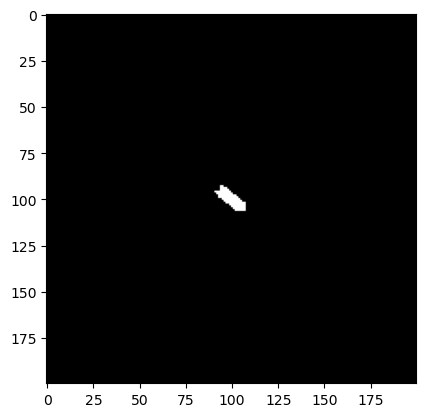

50_1_01ch0_2


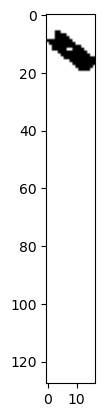

67_2_01ch0_2


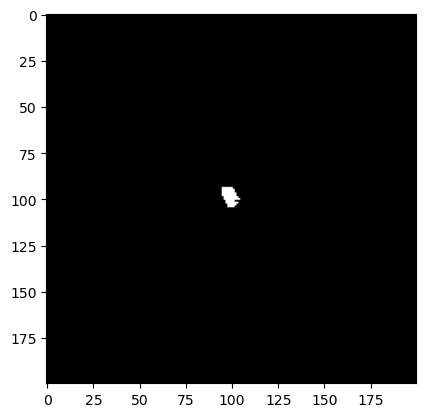

67_2_01ch0_2


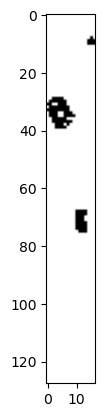

In [205]:
## this is where the image extraction is happening
#for i in range(len(selected_pix_sum)-2): 
particle_df = pd.DataFrame(columns=columns)
for i in range(6):
    # pull out selected area + do analysis
    one_crystal = h5_file['ImageData'][:,int(selected_pix_sum[i]):int(selected_pix_sum[i+1])] # extract 1 crystal
    
    binary_image = (one_crystal == 0) ## important, convert regions where 0 = True (our bits of interest), all else false
    
    labeled_image, num_features = label(binary_image) # identify connected true areas
    # labeled_image = array, with each true area given a number to identify them
    # num_features = number of unique connected components in image. Have to literally have adjacent pixel, not diagonal (this will make them seperate)
    
    props = regionprops(labeled_image) # creates quick list of properties describing each feature detected in the image.
    ## (features are measured in ~ pixels)
    
    if props:
        #start # inner loop for processing each particle # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ #
        for particle in props:
            #plt.imshow(one_crystal, cmap='gray')
            #plt.show()
        # go through each particle detected
            # quickly get rid of tiny particles
            if particle.area >= minimum_area:
                ## more complex stats
                filled_part, spec_region = stats_description(particle,fill_hole_threshold)

                ### quite important, this is remove unwanted particles
                # putting in some conditions to take measurements: d_max needs to be min size, and so does d_min - 4 pixels (remove most streak particles)
                if spec_region:
                    # should this be removed for hvps? - we do new calculation using bounding box
                    #aspect_ratio_value = spec_region.major_axis_length / spec_region.minor_axis_length ## this is very rough, based on equivalent ellipse of the particle (really not accurate) - more just to remove weird looking ones
                    
                    ## euclidean diameter calculation
                    a_particle_coords = particle.coords # basically gives coords of each point of interest [row,column]
                    distances = pdist(a_particle_coords)
                    euclidean_dim = np.max(distances) # max distance between 2 sets of coordinates
                    
                    #if euclidean_dim * pixel_resolution >= length_threshold and spec_region.minor_axis_length > 4 and aspect_ratio_value <10:
                    if euclidean_dim * pixel_resolution >= length_threshold:
                        
                        ## basic info
                        x_coords, y_coords, aspect_ratio_value = coords_etc(a_particle_coords)
                        
                        s_idx = int(selected_pix_sum[i] + x_coords[0])
                        e_idx = int(selected_pix_sum[i] + x_coords[-1])
        
                        ## truncation calc
                        # cnn - in final pic size, particle may be truncated if very long, this tells us how many pixels may be cut off 
                        image_trunc = x_values[-1] - desired_image_size 
                        if image_trunc < 0:
                            image_trunc = 0
                        # normal trunc calculation - on actual probe
                        first_diode, last_diode = calc_truncation(a_particle_coords)
                        
                        ## using circularity calculation from Crosier et al. 2011
                        circularity_calc = np.divide((spec_region.perimeter**2),(4*np.pi*spec_region.area))
                        particle_name = f'{s_idx}_{particle.label}_{date_day}{particle_type}_{h5_additional_label}'
                        
                        # nice way of saving data - lenth + measurements are correct in microns
                        one_particle_data = {
                                #"image_index": image_index,
                                "name": particle_name,
                                "date" : date_str,
                                "slice_s_idx": s_idx,
                                "slice_e_idx": e_idx,
                                #"start_time": str(selected_utc_time[i].values).split('T')[1], # more friendly time
                                #"end_time": str(selected_utc_time[i+1].values).split('T')[1], # more friendly time
                                "ss_start":time_xr['sec_since'][s_idx].values,
                                "ss_end":time_xr['sec_since'][e_idx].values,
                                "x_coords": x_coords,
                                "y_coords": y_coords,
                                #"ellipse_d_max": spec_region.major_axis_length * pixel_resolution, ## d_max (equivalent ellipse)
                                #"ellipse_d_min": spec_region.minor_axis_length * pixel_resolution, ## d_min (equivalent ellipse)
                                "Euclidean_d_max": euclidean_dim * pixel_resolution,
                                "Feret_d_max":spec_region.feret_diameter_max * pixel_resolution,
                                "area": (spec_region.area * (pixel_resolution**2)),
                                "perimeter": (spec_region.perimeter * pixel_resolution),
                                "circularity": circularity_calc,
                                "probe": particle_type,
                                "first_diode_trunc": first_diode,
                                "last_diode_trunc": last_diode,
                                "image_trunc": image_trunc,
                                "aspect_ratio": aspect_ratio_value  
                                }

                        one_particle_data_df = pd.DataFrame([one_particle_data])
                        particle_df = pd.concat([particle_df, one_particle_data_df], ignore_index=True)
                        #file.write(f'{particle_name} stats done \n')
                        
                        ############################# re size + save image ##################################################
                        filled_part = filled_part.astype(np.float32) ## convert to float 0 and 1s
                        filled_part = np.expand_dims(filled_part, axis=-1) ## add extra dimention - this is for adding padding
        
                        imagex = tf.image.resize_with_crop_or_pad(filled_part, desired_image_size, desired_image_size)

                        ## this is checking the image is not blank - written in seperate txt file
                        if np.all(imagex == 0):
                            file.write(f'{particle_name} image is blank - 0s \n')
                        elif np.all(imagex == imagex[0, 0, 0]):
                            file.write(f'{particle_name} image is blank - constant values \n')

                        ## save image
                        # Remove the extra dimension if needed
                        
                        
                        
                        print(particle_name)
                        image_np = imagex.numpy().squeeze()
                        plt.imshow(image_np, cmap="gray")
                        plt.show()

                        print(particle_name)
                        plt.imshow(one_crystal, cmap='gray')
                        plt.show()
                        # Save the image using matplotlib
                        #plt.imsave(f'{flight_save_loc}{particle_name}.png',image_np, cmap="gray")

In [182]:
particle_df

,name,date,slice_s_idx,slice_e_idx,ss_start,ss_end,x_coords,y_coords,Euclidean_d_max,Feret_d_max,area,perimeter,circularity,probe,first_diode_trunc,last_diode_trunc,image_trunc,aspect_ratio
0,50_1_01ch0_2,220801,50,66,65488.497,65604.234,"(0, 16)","(6, 19)",178.885438,197.230829,11100.0,468.700577,1.574919,ch0,0,0,0,1.230769
1,67_2_01ch0_2,220801,67,76,65901.804,65981.676,"(0, 9)","(29, 39)",107.703296,125.299641,7400.0,351.421356,1.328051,ch0,0,0,0,1.111111


In [215]:
def stats_description_2(bw_crystal, fill_hole_thresh):
    #take binary image, fill in small holes and returns object containing stats about crystal
    #plt.imshow(bw_crystal, cmap='gray')
    #plt.show()
    filled_particle = remove_small_holes(bw_crystal.image, area_threshold=fill_hole_thresh) # fill in voids within binary image - better estimation of stats # may need to be altered
    plt.imshow(filled_particle, cmap='gray')
    plt.show()
    if filled_particle.shape[0] < 2 or filled_particle.shape[1] < 2:
        return None, None
        
    contours = measure.find_contours(filled_particle, 0.5)
    if contours:
        contour = max(contours, key=lambda x: x.shape[0])  # Sort contours by area (largest first) and select the largest contour
        
        labeled_image = measure.label(filled_particle)  # Label the image based on the threshold
        region = measure.regionprops(labeled_image)[0]  # Assumes largest labeled region corresponds to largest contour
        
        return filled_particle, region
    else:
        return None, None

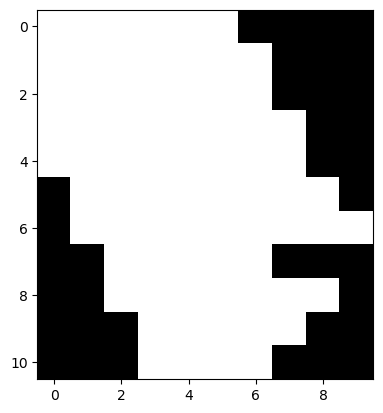

11
10


In [216]:
i = 1
#plt.imshow(one_crystal, cmap='gray')
#plt.show()
'''
for particle in props:
    print(i)
    filled_part, spec_region = stats_description(particle,fill_hole_threshold)
    plt.imshow(filled_part, cmap='gray')
    plt.show()
    i += 1
'''
filled_part, spec_region = stats_description_2(props[1],fill_hole_threshold)
#plt.imshow(filled_part, cmap='gray')
#plt.show()
#print(spec_region)
#plt.imshow(filled_part)

#plt.show()
#num_features
print(filled_part.shape[0])
print(filled_part.shape[1])

In [115]:
print(particle_name)
y_coords = [a_particle_coords[0][0],a_particle_coords[-1][0]]
x_coords = [x_values[0], x_values[-1]]
y_length = y_coords[1] - y_coords[0]
x_length = x_coords[1] - x_coords[0]

max_dim = max([y_length,x_length])
min_dim = min([y_length,x_length])
print(y_coords)
print(x_coords)
print(y_length)
print(x_length)

print(f'max dim: {max_dim}')
print(f'min dim: {min_dim}')
bb_aspect_ratio = max_dim/min_dim
print(bb_aspect_ratio)

7136_1_01ch0_2
[90, 108]
[0, 13]
18
13
max dim: 18
min dim: 13
1.3846153846153846


In [74]:
[x_values[0], x_values[-1]]

[0, 9]

In [93]:
s = particle_df['ss_start'][18]
e = particle_df['ss_end'][18]

print(f'{s} {e}')
print(e-s)

66836.121 66836.152
0.031000000002677552


In [107]:
h5_file.close()